<a href="https://colab.research.google.com/github/zulfiqaralimir/Geo-Spacial-Data/blob/master/Normalization_and_Compression_of_Sparse_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### MODULE 7 | LESSON 2

# **Matrix Normalization and Sparse Climate Data Compression**

|  |  |
|:---|:---|
|**Reading Time** |60 minutes|
|**Prior Knowledge** |Basic Python|
|**Keywords** |climate data, matrix normalization, standardization, min-max scaling, robust scaling, temporal normalization, compressed sparse row format
 |
|  |  |

## **1. Introduction**
In previous lessons, we learned the basics of climate data. In this lesson, we are going to learn how to **manipulate climate data in a matrix form**.

The first step we will learn is to normalize matrix climate data.

We will introduce three normalization methods:

- Z-score normalization,
- min-max scaling, and
- log transformation.

We will also provide applications to demonstrate how to use these methods. Next, we will talk about sparse matrices. We will describe what a sparse matrix is and its issues in data analysis. Then, we'll introduce a method for handling a sparse matrix data. But first, let's introduce the dataset we'll use in this lesson.
<br>
<br>
## **2. Dataset**
### **2.1 Financial Data**
For this lesson, we will use both climate data and financial data.
<br>
For financial data, we will use the daily price of SPY, SPDR S&P 500 Index ETF Trust, from 2010 to 2023. SPY is the most widely traded ETF and is commonly used as the benchmark for the U.S. stock market's overall performance.

Let's pull this data from Yahoo's website first.

In [1]:
import pandas as pd
import requests
from io import StringIO
import datetime
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yfin
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from scipy.sparse import csr_matrix

In [10]:
import yfinance as yf

# Pull S&P 500 ETF price data
start = "2010-01-01"
end = "2023-12-31"
stocks = yf.download("SPY", start=start, end=end)

# Access adjusted close price (auto-adjusted 'Close')
adj_close = stocks[("Close", "SPY")]
print(adj_close.head())


/tmp/ipython-input-10-2784898750.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stocks = yf.download("SPY", start=start, end=end)
[*********************100%***********************]  1 of 1 completed

Date
2010-01-04    85.515633
2010-01-05    85.742012
2010-01-06    85.802368
2010-01-07    86.164574
2010-01-08    86.451309
Name: (Close, SPY), dtype: float64


In [11]:
# Create an index for the stock dataframe
stocks.index = pd.to_datetime(stocks.index).strftime("%Y-%m-%d")

### **2.2 Climate Data**
In this section, we are going to demonstrate how to pull climate data from the National Centers for Environmental Information. **The National Centers for Environmental Information (NCEI)** is a division of NOAA (National Oceanic and Atmospheric Administration) and maintains one of the world's largest repositories of environmental data. Its data includes climate data, ocean data, and satellite data.
<br>
<br>
We will extract some climate data from the **Global Historical Climatology-Daily (GHCN-Daily)** database of NCEI. GHCN-Daily combines daily climate data from approximately 30 different data sources. It collects data measurements from over 90,000 land-based stations worldwide. You can find more information about the GHCN-Daily database [here](https://www.ncei.noaa.gov/metadata/geoportal/rest/metadata/item/gov.noaa.ncdc:C00861/html).
<br>
<br>
In our case, we will extract our climate data measured at the station in Central Park, New York City, New York, in the United States. The station id code is "USW00094728". You can find the list of all station identifiers for GHCN-Daily [here](https://www.ncei.noaa.gov/pub/data/ghcn/daily/ghcnd-stations.txt).
<br>
<br>
We are going to pull the following daily climate variables between 2010 and 2023:
<br>
<br>
PRCP: Precipitation (millimeters, mm)
<br>
SNOW: Snowfall (centimeter, cm)
<br>
TMAX: Daily Max Temperature (Degrees, Celsius)
<br>
TMIN: Daily Min Temperature (Degrees, Celsius)
<br>
AWND: Daily wind speed (Meters per second, m/s)
<br>
RHAV: Relative Humidity (%)
<br>
<br>
For a whole list of available climate variables in the GHCN-Daily database, go [here](https://www.ncei.noaa.gov/data/global-historical-climatology-network-daily/doc/GHCND_documentation.pdf).

In [12]:
#Access data through NCEI API

#Set parameters
dataset = "daily-summaries"                   # this is the name for GHCN-Daily database
vars = "PRCP, SNOW, TMIN, TMAX, AWND, RHAV"   # climate variable symbols
station_id = "USW00094728"                    # New York Central Park station identifier
st_dt = "2010-01-01"                          # start date
end_dt = "2023-12-31"                         # end date

api_base = "https://www.ncei.noaa.gov/access/services/data/v1?"
req_params ="dataset=" + dataset + "&dataTypes=" + vars + "&stations=" + station_id + "&startDate=" + st_dt + "&endDate=" + end_dt + "&includeStationName=true&units=metric"
req_str = api_base + req_params
data = requests.get(req_str)

In [13]:
#Convert the downloaded data into a pandas dataframe
s=str(data.content,'utf-8')
data_s = StringIO(s)
climate=pd.read_csv(data_s)

In [14]:
climate.head()

,STATION,NAME,DATE,AWND,PRCP,RHAV,SNOW,TMAX,TMIN
0,USW00094728,"NY CITY CENTRAL PARK, NY US",2010-01-01,1.5,0.8,83.0,0.0,4.4,0.6
1,USW00094728,"NY CITY CENTRAL PARK, NY US",2010-01-02,5.6,0.5,61.0,5.0,1.1,-8.3
2,USW00094728,"NY CITY CENTRAL PARK, NY US",2010-01-03,6.4,0.0,56.0,0.0,-5.6,-8.3
3,USW00094728,"NY CITY CENTRAL PARK, NY US",2010-01-04,4.8,0.0,56.0,0.0,-1.1,-7.2
4,USW00094728,"NY CITY CENTRAL PARK, NY US",2010-01-05,4.4,0.0,56.0,0.0,-1.1,-6.7


We now have both a financial dataset and a climate dataset, so let's merge the two datasets together using the common variables.

In [20]:
import yfinance as yf
import pandas as pd

# Step 1: Download stock data
start = "2010-01-01"
end = "2023-12-31"
stocks = yf.download("SPY", start=start, end=end)

# Step 2: Extract adjusted close price
adj_close = stocks[("Close", "SPY")]
stocks_single_level_df = adj_close.to_frame(name="Adj_Close").reset_index()

# Step 3: Convert climate['DATE'] to datetime format
climate['DATE'] = pd.to_datetime(climate['DATE'])

# Step 4: Merge on datetime columns
climate_stock = climate.merge(stocks_single_level_df, left_on='DATE', right_on='Date', how='inner')

# Step 5: View merged data
climate_stock.head()


/tmp/ipython-input-20-4047179177.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stocks = yf.download("SPY", start=start, end=end)
[*********************100%***********************]  1 of 1 completed


,STATION,NAME,DATE,AWND,PRCP,RHAV,SNOW,TMAX,TMIN,Date,Adj_Close
0,USW00094728,"NY CITY CENTRAL PARK, NY US",2010-01-04,4.8,0.0,56.0,0.0,-1.1,-7.2,2010-01-04,85.515633
1,USW00094728,"NY CITY CENTRAL PARK, NY US",2010-01-05,4.4,0.0,56.0,0.0,-1.1,-6.7,2010-01-05,85.742012
2,USW00094728,"NY CITY CENTRAL PARK, NY US",2010-01-06,4.3,0.0,56.0,0.0,1.1,-3.3,2010-01-06,85.802368
3,USW00094728,"NY CITY CENTRAL PARK, NY US",2010-01-07,3.9,0.0,63.0,0.0,2.8,-1.1,2010-01-07,86.164574
4,USW00094728,"NY CITY CENTRAL PARK, NY US",2010-01-08,3.4,1.3,70.0,15.0,0.6,-5.0,2010-01-08,86.451309


The above dataset now includes both financial and climate data. We also know that different variables have different measurement units. In the following sections, we will talk about how to normalize these climate and financial variables for financial analysis.

## **3. Matrix Normalization for Climate Data**
### **3.1 Why Do We Need Matrix Normalization?**
<br>
A lot of data comes in matrix form, including climate data. For example, you might get climate data for a location in matrix form. In the climate data matrix, there can be a temperature column, a wind speed column, and a precipitation column. They represent different variables in the data matrix. There can be several rows in the data matrix to represent dates and their values in the temperature, wind speed, and precipitation variables. To be more specific, each row can be the daily average measurements of these variables. This is a very structured data matrix. However, there are a few issues in this data matrix we need to address before using it for analysis.

1. Variables in the climate data matrix have different measurement units or scales. We cannot directly compare between these variables.
2. Variables in the climate data matrix have different data distributions. Many financial analysis techniques require normal distribution of the data.
3. Many financial analysis techniques also require data normalization as a prerequisite.

Our dataset clearly suffers from issue 1. In our dataset, there are 6 climate variables with 5 different measurement units. Once we add SPY variable into the dataset, we will have 7 variables with 6 different measurement units.
<br>
Our dataset also suffers from issue 2, where different variables have different distributions. Let's use the following graph to demonstrate this issue.

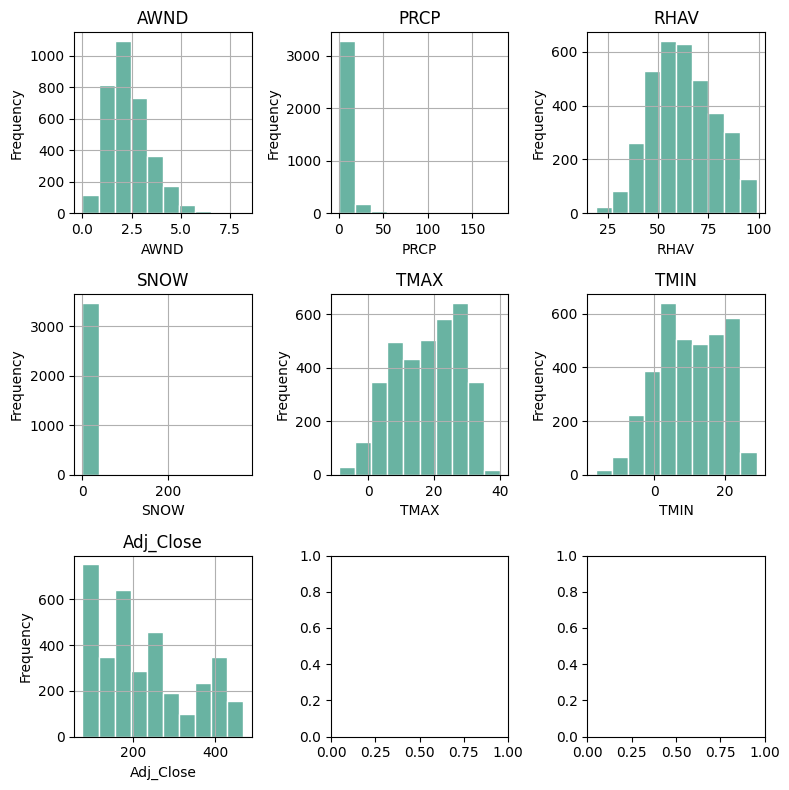

In [25]:
# Show histogram for each variable to demonstrate issue 2
# Initialize a 3x3 charts
def hist_graph(dataset_x, var_list, row, col):
      fig, axes = plt.subplots(nrows=row, ncols=col, figsize=(8, 8))

      # Flatten the axes array (makes it easier to iterate over)
      axes = axes.flatten()

      dataset_y = dataset_x[var_list]
      # Loop through each column and plot a histogram
      for i, column in enumerate(dataset_y.columns):

            # Add the histogram
            dataset_y[column].hist(ax=axes[i], # Define on which ax we're working on
                            edgecolor='white', # Color of the border
                            color='#69b3a2' # Color of the bins
                          )

            # Add title and axis label
            axes[i].set_title(column)
            axes[i].set_xlabel(column)
            axes[i].set_ylabel('Frequency')

      # Adjust layout
      plt.tight_layout()

      # Show the plot
      plt.show()

hist_graph(climate_stock, ["AWND","PRCP","RHAV","SNOW","TMAX","TMIN","Adj_Close"],3,3)

From the above histograms, we can see there are various distributions among the variables in our dataset. Hence, issue 2 is also a problem we need to handle for the dataset. The first normalization method we are going to introduce is called standardization.
<br>
<br>
### **3.2 Standardization (Z-score Normalization)**
**Standardization (Z-Score Normalization)** transforms features to have zero mean and unit variance, following the formula:
<br>
$$z = (x - μ) / σ$$
where:
<br>
x is the original value
<br>
μ is the mean of the feature
<br>
σ is the standard deviation
<br>
<br>
Standardization ensures all input features contribute equally to the model, reducing bias from features with larger scales. Standardization is suitable when the feature has a normal distribution. This method does not account for features with many outliers and non-normal distributions. It is recommended to remove outliers before conducting standardization. PCA and cluster analysis always require the dataset to be standardized first. Standardized datasets are also suitable for linear regression models and other models requiring normal distribution.
<br>
<br>
Now, let's standardize variables/features in our climate-finance dataset.

In [28]:
# Standardize all variables in the dataset
def standardization(data_x, var_list):
    # Create a StandardScaler object
    scaler = StandardScaler()

    # Fit the scaler to the data and transform it
    data_x_2 = data_x[var_list]
    data_x_std = pd.DataFrame(scaler.fit_transform(data_x_2))
    data_x_std.columns = var_list
    return data_x_std

climate_stock_std = standardization(climate_stock, ["AWND","PRCP","RHAV","SNOW","TMAX","TMIN","Adj_Close"])
climate_stock_std.head()

,AWND,PRCP,RHAV,SNOW,TMAX,TMIN,Adj_Close
0,2.299840,-0.370831,-0.372768,-0.115262,-1.901963,-1.879719,-1.271751
1,1.924686,-0.370831,-0.372768,-0.115262,-1.901963,-1.824842,-1.269712
2,1.830897,-0.370831,-0.372768,-0.115262,-1.680059,-1.451675,-1.269168
3,1.455743,-0.370831,0.069677,-0.115262,-1.508587,-1.210214,-1.265905
4,0.986800,-0.241007,0.512122,0.671979,-1.730491,-1.638258,-1.263322


In [29]:
means = climate_stock_std.mean()
print(means)

AWND        -1.013553e-16
PRCP         4.841859e-17
RHAV         1.520537e-16
SNOW        -2.017441e-18
TMAX        -6.455811e-17
TMIN         1.634127e-16
Adj_Close    1.291162e-16
dtype: float64


In [30]:
vars = climate_stock_std.var()
print(vars)

AWND         1.000297
PRCP         1.000284
RHAV         1.000289
SNOW         1.000284
TMAX         1.000284
TMIN         1.000284
Adj_Close    1.000284
dtype: float64


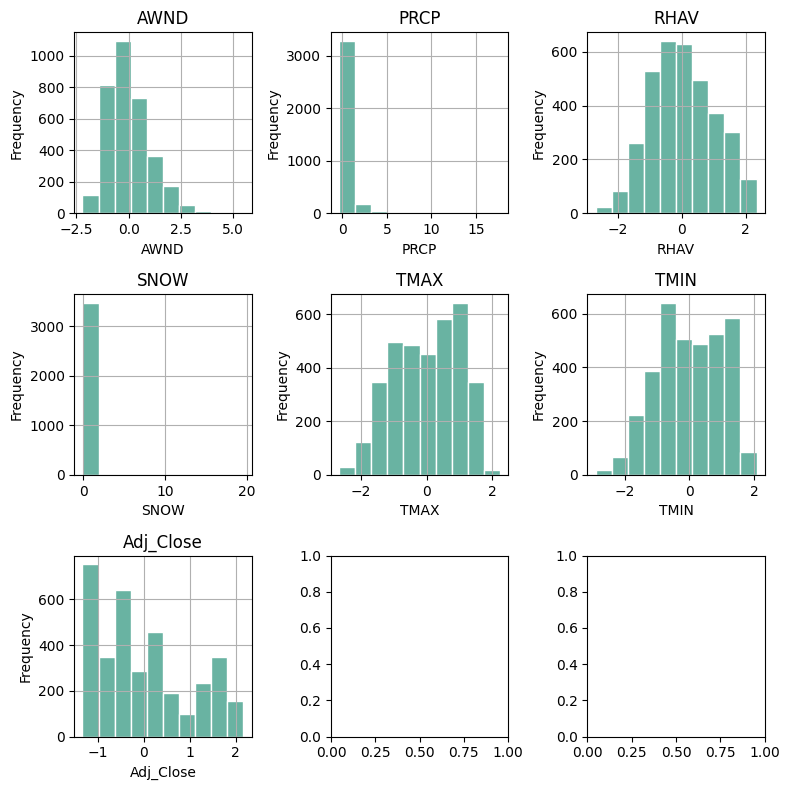

In [32]:
# Draw histograms of standardized variables
hist_graph(climate_stock_std, ["AWND","PRCP","RHAV","SNOW","TMAX","TMIN","Adj_Close"],3,3)

From the above result, we can see after standardization that the means for all standardized variables are 0 and the variances of all standardized variables are 1. Now all the standardized variables are of the same scale. The histograms of all standardized variables demonstrate the same distribution shapes as the histograms of the original variables. This standardization will preserve the shape of the data distribution.
<br>
<br>
### **3.3 Min-Max Scaling**
**Min-max Scaling**, also called **normalization**, transforms features to a fixed range [0,1] using the following formula:
<br>
<br>
$$x' = (x - min(x)) / (max(x) - min(x))$$
<br>
When $x$ is $min(x)$, then $x'$ is 0
<br>
When $x$ is $max(x)$, then $x'$ is 1
<br>
When $min(x) < x < max(x)$, then $x'$ is between 0 and 1
<br>
<br>
Min-max scaling is very useful when applied to datasets for machine learning models. Datasets transfromed with min-max scaling will have smaller scales and will be useful for neural network models or image processing models. Min-max scaling is suitable for a dataset that has a known upper bound and a known lower bound with few outliers. This method is also good for features without any assumptions of their distribution. Just like the standardization method, min-max scaling does not handle outliers well.

In [34]:
# Use Min-max scaling to normalize all variables in the dataset
def min_max_scaling(data_x, var_list):
    # Create a MinMaxScaler object
    scaler_n = MinMaxScaler()

    # Fit the scaler to the data and transform it
    data_x_2 = data_x[var_list]
    data_x_nor = pd.DataFrame(scaler_n.fit_transform(data_x_2))
    data_x_nor.columns = [var_list]
    return data_x_nor

climate_stock_nor = min_max_scaling(climate_stock, ["AWND","PRCP","RHAV","SNOW","TMAX","TMIN","Adj_Close"])
climate_stock_nor.head()

,AWND,PRCP,RHAV,SNOW,TMAX,TMIN,Adj_Close
0,0.585366,0.000000,0.4625,0.000000,0.157787,0.206593,0.019773
1,0.536585,0.000000,0.4625,0.000000,0.157787,0.217582,0.020353
2,0.524390,0.000000,0.4625,0.000000,0.202869,0.292308,0.020508
3,0.475610,0.000000,0.5500,0.000000,0.237705,0.340659,0.021436
4,0.414634,0.007178,0.6375,0.039894,0.192623,0.254945,0.022172


In [35]:
# Show the minimum values of all min-max scaled/ normalized variables
mins = climate_stock_nor.min()
print(mins)

AWND         0.0
PRCP         0.0
RHAV         0.0
SNOW         0.0
TMAX         0.0
TMIN         0.0
Adj_Close    0.0
dtype: float64


In [36]:
# Show the maximum values of all min-max scaled/normalized variables
maxs = climate_stock_nor.max()
print(maxs)

AWND         1.0
PRCP         1.0
RHAV         1.0
SNOW         1.0
TMAX         1.0
TMIN         1.0
Adj_Close    1.0
dtype: float64


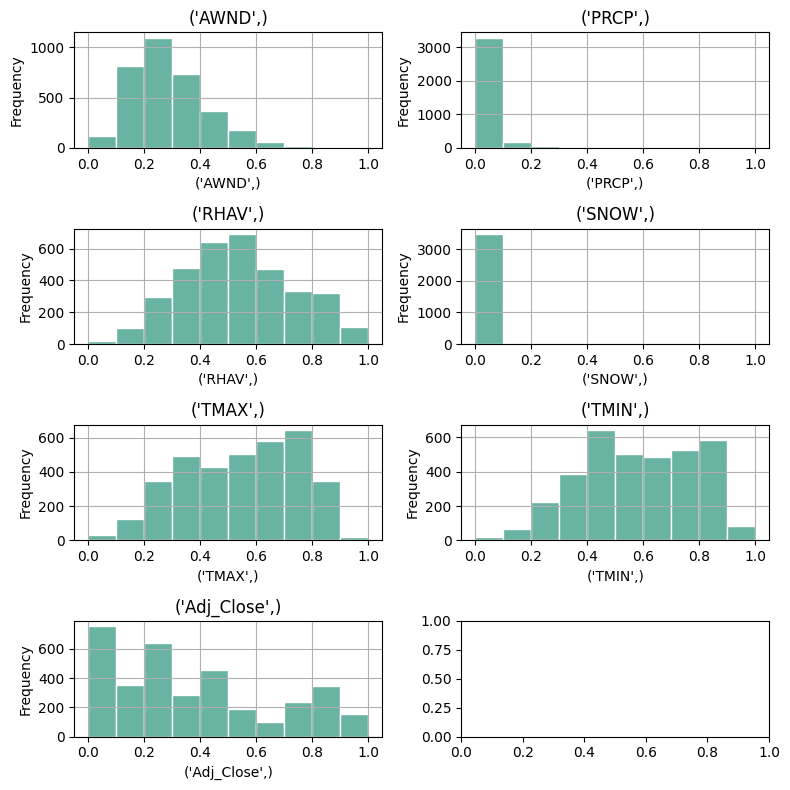

In [37]:
# Draw histograms of min-max scaled variables
hist_graph(climate_stock_nor, ["AWND","PRCP","RHAV","SNOW","TMAX","TMIN","Adj_Close"],4,2)

The above example demonstrates how to implement min-max scaling/normalization for a dataset in Python. The example shows that after the normalization, the range of all normalized variables is between 0 and 1. The histograms of normalized variables also show the same result. Same as the standardization method, the min-max scaling method also preserves data distribution after normalization.
<br>
<br>
###**3.4 Robust Scaling**
We learned in the previous sections that **standardization and min-max scaling methods are sensitive to outliers** in a dataset. In this section, we will introduce a new normalization method that can handle the outlier issue.
<br>
**Robust scaling** is a normalization method that is not sensitive to the existence of outliers in a dataset. Robust scaling uses a median and quartiles to avoid the extreme values in a dataset. Here is its formula.
<br>
<br>
$$x' = (x - median(x)) / IQR(x)$$
<br>
<br>
where $IQR(x)$ is the interquartile range. In this case, we use the range between the 1st quartile and 3rd quartile of $x$
<br>
<br>
By using statics like **median and IQR, robust scaling can avoid the use of extreme values when normalizing the dataset**. Hence, robust scaling is suitable for handling datasets with outliers and also datasets of non-normal distribution.
<br>
Let's apply robust scaling to our dataset.

In [39]:
# Use Robust scaling to normalize all variables in the dataset
def robust_scaling(data_x, var_list):
    # Create a RobustScaler object
    scaler_r = RobustScaler()

    # Fit the scaler to the data and transform it
    data_x_2 = data_x[var_list]
    data_x_rob = pd.DataFrame(scaler_r.fit_transform(data_x_2))
    data_x_rob.columns = [var_list]
    return data_x_rob

climate_stock_rob = robust_scaling(climate_stock, ["AWND","PRCP","RHAV","SNOW","TMAX","TMIN","Adj_Close"])
climate_stock_rob.head()

,AWND,PRCP,RHAV,SNOW,TMAX,TMIN,Adj_Close
0,1.857143,0.000000,-0.217391,0.0,-1.161677,-1.109677,-0.658602
1,1.571429,0.000000,-0.217391,0.0,-1.161677,-1.077419,-0.657262
2,1.500000,0.000000,-0.217391,0.0,-1.029940,-0.858065,-0.656905
3,1.214286,0.000000,0.086957,0.0,-0.928144,-0.716129,-0.654762
4,0.857143,0.722222,0.391304,15.0,-1.059880,-0.967742,-0.653065


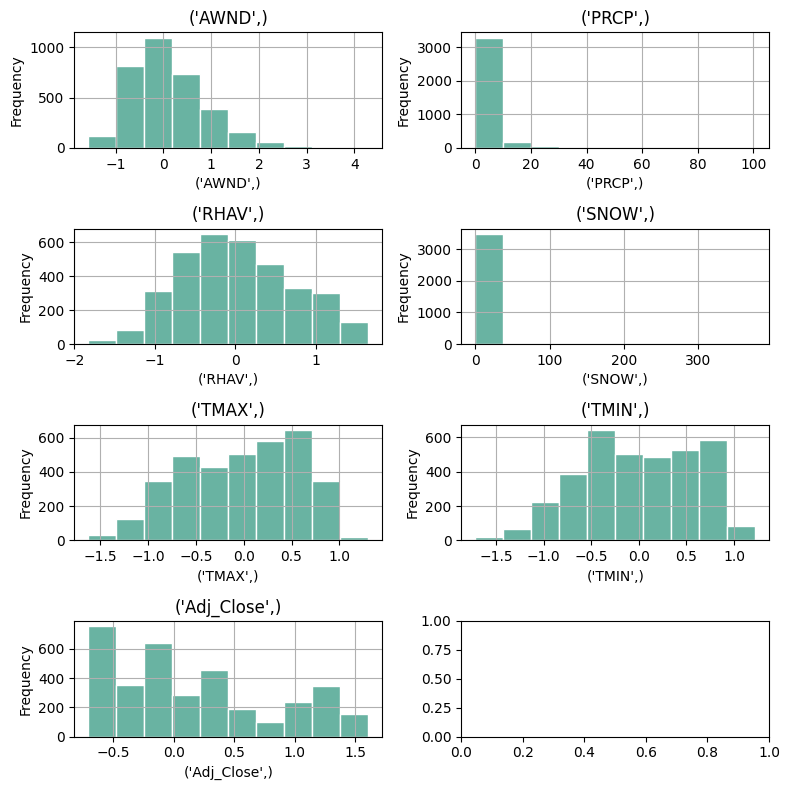

In [40]:
# Draw histograms of robust scaled variables
hist_graph(climate_stock_rob, ["AWND","PRCP","RHAV","SNOW","TMAX","TMIN","Adj_Close"],4,2)

We can see from the above histograms that robust scaling also maintains the original data distribution shape.
<br>
<br>
###**3.5 Time Series Temporal Normalization**
So far, we have been discussing various normalization methods for a dataset in general. In this section, we will focus on time series data. We will also introduce a method for time series temporal normalization.
<br>
In machine learning, we usually talk about **feature engineering**. **Feature engineering** is a technique to transform raw data for the use of machine learning models. Normalization is a method of feature engineering.
<br>
Time series data is special in the sense that it has the additional temporal feature in the dataset. For time series normalization, we can use the above discussed normalization methods. However, those methods do not account for the time element in the time series data.
<br>
In this section, we are going to introduce a **rolling average** normalization method for time series data. Different from the standardization method using mean and standard deviation of the whole dataset, rolling average normalization uses the most recent data points to calculate the mean and the standard deviation. Hence, a user needs to decide how far back the data should be used to calculate the mean and the standard deviation. We call this looking back period "Window." For example, if we would like to use data from the latest 30 days to calculate mean and standard deviation, the window is 30 days. We call this mean and standard deviation the rolling mean and rolling standard deviation. We then apply the rolling mean and rolling standard deviation to each data point as we use the standardization method.
<br>
Instead of using a static mean and standard deviation, rolling average normalization uses a dynamic mean and standard deviation to standardize time series data.
<br>
Let's first look at the time series graph for all variables in our dataset.

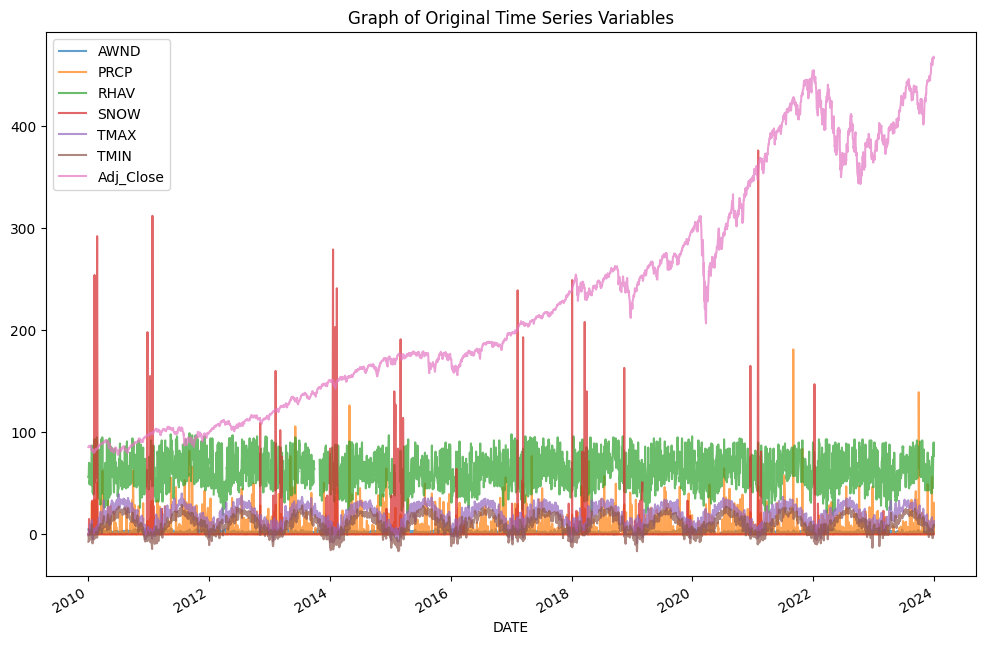

In [41]:
# Original Time Series graph
climate_stock_g = climate_stock[["DATE","AWND","PRCP","RHAV","SNOW","TMAX","TMIN","Adj_Close"]]
climate_stock_g.set_index('DATE', inplace=True)
climate_stock_g.plot(figsize=(12, 8), title='Graph of Original Time Series Variables', alpha=0.7)
plt.show()

From the above graph, SPY has a significant trend. The rest of the climate variables all have a clear seasonal pattern. Now let's implement the rolling average normalization in Python.

In [42]:
# Rolling Average normalization for time seris data
def normalize_temporal_features(X, window_size):
    rolling_mean = X.rolling(window=window_size).mean()
    rolling_std = X.rolling(window=window_size).std()
    return (X - rolling_mean) / rolling_std

climate_stock_t_n = normalize_temporal_features(climate_stock[["AWND","PRCP","RHAV","SNOW","TMAX","TMIN","Adj_Close"]], 30)
climate_stock_t_n.columns = ["AWND","PRCP","RHAV","SNOW","TMAX","TMIN","Adj_Close"]
climate_stock_t_n.head(50)

,AWND,PRCP,RHAV,SNOW,TMAX,TMIN,Adj_Close
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Let's draw a time series graph for the normalized data to better understand the change after applying rolling average normalization.

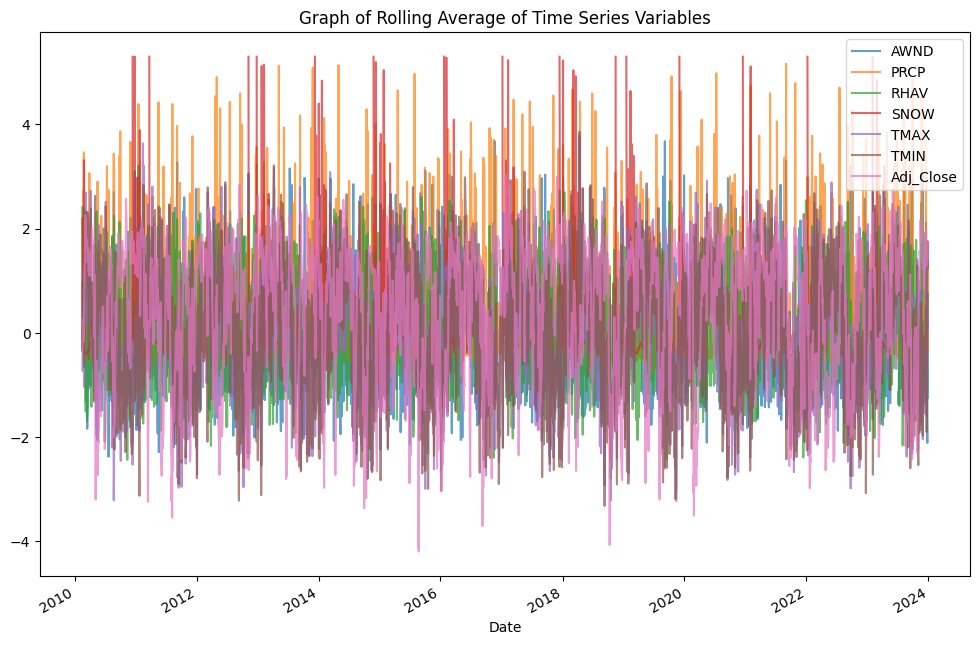

In [43]:
# Rolling Average Time series graph
climate_stock_t_n["Date"] = climate_stock["DATE"]
climate_stock_t_n.set_index('Date', inplace=True)
climate_stock_t_n.plot(figsize=(12, 8), title='Graph of Rolling Average of Time Series Variables', alpha=0.7)
plt.show()

From the above graph, we can see that normalized SPY just oscillating around 0 without any discernible trend. Other climate variables also oscillate around 0 but still demonstrate a seasonal pattern. With this exercise, we can easily detect seasonal patterns and trends for temporal climate data.
<br>
<br>
###**3.6 Integration for Multi-Normalization Features**
We introduced several normalization methods in the previous sections. Sometimes we would like to apply different normalization methods to different features. We can normalize a feature with a specific normalization method and then put all normalized features into one dataset for analysis. Let's demonstrate this with the following Python code.

In [44]:
#Normalize variables based on the following rules
#Stardardization : AWND, TMAX, TMIN
# Min-max Scaling: RHAV
# Robust Scaling: PRCP, SNOW
# Rolling Average: SPY

combined_data = pd.DataFrame(climate_stock["DATE"])
combined_data[["AWND","TMAX","TMIN"]] = standardization(climate_stock, ["AWND","TMAX","TMIN"])
combined_data[["RHAV"]] = min_max_scaling(climate_stock, ["RHAV"])
combined_data[["PRCP","SNOW"]] = robust_scaling(climate_stock, ["PRCP", "SNOW"])
combined_data[["SPY"]] = normalize_temporal_features(climate_stock[["Adj_Close"]], 30)
combined_data.set_index('DATE', inplace=True)

combined_data.head(50)

,AWND,TMAX,TMIN,RHAV,PRCP,SNOW,SPY
DATE,,,,,,,
2010-01-04,2.299840,-1.901963,-1.879719,0.4625,0.000000,0.0,NaN
2010-01-05,1.924686,-1.901963,-1.824842,0.4625,0.000000,0.0,NaN
2010-01-06,1.830897,-1.680059,-1.451675,0.4625,0.000000,0.0,NaN
2010-01-07,1.455743,-1.508587,-1.210214,0.5500,0.000000,0.0,NaN
2010-01-08,0.986800,-1.730491,-1.638258,0.6375,0.722222,15.0,NaN
2010-01-11,0.799223,-1.851530,-1.758989,0.3750,0.000000,0.0,NaN
2010-01-12,1.737109,-1.619539,-1.572406,0.4250,0.000000,0.0,NaN
2010-01-13,1.174377,-1.619539,-1.572406,0.4250,0.000000,0.0,NaN
2010-01-14,-0.795182,-1.226164,-1.210214,0.4375,0.000000,0.0,NaN


##**4. Sparse Climate Data**
Sparse climate data represents one of the most significant challenges in climate science. When scientists attempt to analyze climate patterns, they often encounter missing values in data that can span years, decades, or even centuries. These missing values can be due to disruptive events or natural disasters that prevented the collection of data. It can also be the inconsistent frequency of data collection. Remote locations or other geographical restrictions can also make data inaccessible. Sometimes, the equipment or sensor issues can also disrupt the collection of data.
<br>
<br>
###**4.1  Challenges and Mitigation Measures for Sparse Climate Data**
With the data gap, there will be challenges to scientific research and statistical analysis. Without complete data, the implications for scientific research are low confidence for trend analysis, signals that are hard to identify, difficulty with model validation, and low accuracy for weather forecasts. For statistical analysis, the uncertainty of the prediction will be wider and the statistical power will be lower.
<br>
In order to mitigate the impact of sparse climate data, scientists have a few measures they can take. The first one is to use imputation techniques to add imputed values to the dataset. The other one is the interpolation technique. We won't go into details for these methods.
<br>
<br>
###**4.2 Compression of Sparse Data Matrix**
In the pervious section, we talked about the challenges using a sparse matrix for analysis and methods to mitigate the issue. In this section, we are going to discuss another issue with sparse matrix: data storage. As described previously, a sparse matrix contains a lot of zeros in the matrix. To store the sparse matrix with all the zeros in the memory will waste a lot of computer space. In machine learning, it's essential to break up the data matrix in the memory so that it's an appropriate size and move it to the RAM before computing. Using the original sparse matrix for modeling will take up a lot of resources and reduce the computer's efficiency. For this reason, there are several sparse matrix compression methods that have been developed. One of the most popular methods is the compressed sparse row.
<br>
<br>

####**4.2.1 Compressed Sparse Row Format**
**Compressed sparse row or CSR** is the method of compressing data from a sparse data matrix to reduce data storage space. In general, a sparse row is a row where half of its values are zeros. Let's use the following example to explain what CSR is and how it works.
<br>
Suppose we have the following matrix:
<br>
<br>
$$\begin{bmatrix}
3 & 0 & 0 & 7 & 0 \\
2 & 10 & 9 & 6 & 0 \\
5 & 0 & 0 & 8 & 13 \\
0 & 0 & 4 & 7 & 0 \\
0 & 0 & 0 & 0 & 15
\end{bmatrix}$$
<br>
<br>
In order to convert this matrix into a CSR format, we first need to count how many non-zero numbers we have in the matrix. In the above matrix, there are 12 non-zero values. Let's give all these non-zero values an id and present them in the following table.
<br>
<br>
**Table 1**

|Non-Zero ID|0|1|2|3|4|5|6|7|8|9|10|11|
|---|---|---|---|---|---|---|---|---|---|---|---|---|
|Value|3|7|2|10|9|6|5|8|13|4|7|15|
<br>

In the above table 1, we start from the top row and go from left to right to record each non-zero number and assign an id to it. The next step is to add column id to table 1. We will assign column id 0 to the values on the left-most column and column id 4 to the values on the right-most column. Column id 1, 2, 3 will be assigned to the values on the columns in between. The result will be as follows.
<br>
<br>
**Table 2**

|Non-Zero ID|0|1|2|3|4|5|6|7|8|9|10|11|
|---|---|---|---|---|---|---|---|---|---|---|---|---|
|Value|3|7|2|10|9|6|5|8|13|4|7|15|
|Column ID|0|3|0|1|2|3|0|3|4|2|3|4|
<br>
<br>

The next information we will need is row pointer. To find this information, first, we need to identify the first non-zero number (from left to right) of each row. In our matrix, the first non-zero numbers of rows are 3, 2, 5, 4, and 15 as highlighted in yellow in the following matrix.

<br>
<br>
$$\begin{bmatrix}
\bbox[yellow]{3} & 0 & 0 & 7 & 0 \\
\bbox[yellow]{2} & 10 & 9 & 6 & 0 \\
\bbox[yellow]{5} & 0 & 0 & 8 & 13 \\
0 & 0 & \bbox[yellow]{4} & 7 & 0 \\
0 & 0 & 0 & 0 & \bbox[yellow]{15}
\end{bmatrix}$$
<br>
<br>

Once we identify the first non-zero numbers for all rows, we can mark them with their corresponding Non-Zero ID on the table 2 as follows:
<br>
<br>
**Table 3**

|Non-Zero ID|$\bbox[yellow]{0}$|1|$\bbox[yellow]{2}$|3|4|5|$\bbox[yellow]{6}$|7|8|$\bbox[yellow]{9}$|10|$\bbox[yellow]{11}$|
|---|---|---|---|---|---|---|---|---|---|---|---|---|
|Value|$\bbox[yellow]{3}$|7|$\bbox[yellow]{2}$|10|9|6|$\bbox[yellow]{5}$|8|13|$\bbox[yellow]{4}$|7|$\bbox[yellow]{15}$|
|Column ID|0|3|0|1|2|3|0|3|4|2|3|4|

<br>
<br>
Then, we can collect all highlighted Non-Zero IDs from left to right in table 3 and put them in an array as follows:
<br>
<br>
$$\left[ 0,2,6,9,11 \right]$$
<br>

In order to provide ending information to the CRS, we need to add one extra number to the right side of this array. The number to add to the array is **the largest Non-Zero ID + 1**. In our case it is 11+1 = 12. Let's add 12 to the right side of this array.
<br>
<br>
$$\left[ 0,2,6,9,11,12 \right]$$
<br>
<br>
The above array is our row pointer array.
<br>
<br>
Now we can assemble all the information we collected to form CSR. For the CSR format of our matrix, there are 3 one-dimensional arrays.
<br>
<br>
Value array:$\left[ 3,7,2,10,9,6,5,8,13,4,7,15 \right]$
<br>
Column array:$\left[ 0,3,0,1,2,3,0,3,4,2,3,4 \right]$
<br>
Row pointer array:$\left[ 0,2,6,9,11,12 \right]$
<br>
<br>
With only 3 one-dimensional arrays in CSR format, we can store the information of a sparse matrix with many zeros in a more efficient way. This compression technique not only saves storage space and utilizes computer memory more efficiently but also optimizes the processing of many machine learning models.
<br>
Now we know the basics of CSR. Let's use Python to derive a CSR format for our matrix.

In [45]:
# Set up the matrix
s_matrix = np.matrix([[3,0,0,7,0],
                      [2,10,9,6,0],
                      [5,0,0,8,13],
                      [0,0,4,7,0],
                      [0,0,0,0,15]])

# Convert to CSR format
csr = csr_matrix(s_matrix)

# Print value array
csr_value = csr.data
csr_value

array([ 3,  7,  2, 10,  9,  6,  5,  8, 13,  4,  7, 15])

In [46]:
# Print column id array
csr_col = csr.indices
csr_col

array([0, 3, 0, 1, 2, 3, 0, 3, 4, 2, 3, 4], dtype=int32)

In [47]:
# Print row pointer array
csr_row_ptr = csr.indptr
csr_row_ptr

array([ 0,  2,  6,  9, 11, 12], dtype=int32)

From the above Python result, we can use Python to produce three arrays of CSR format for our matrix. Now let's try to do the reverse. Suppose I have the CSR format information about a sparse matrix, let's use Python to reconstruct the matrix.

In [48]:
# Reconstruct the matrix from 3 arrays from CSR
mtx = csr_matrix((csr_value, csr_col, csr_row_ptr)).toarray()
mtx

array([[ 3,  0,  0,  7,  0],
       [ 2, 10,  9,  6,  0],
       [ 5,  0,  0,  8, 13],
       [ 0,  0,  4,  7,  0],
       [ 0,  0,  0,  0, 15]])

The above csr_matrix function uses CSR format as input to reconstruct the matrix. Now we learn how to compress a sparse matrix to a CSR format and reconstruct a matrix using CSR format as input. There are several other compression methods to compress a sparse matrix. We will not dive in more. For readers who are interested in this topic, there are plenty of resources available online.
<br>
<br>
####**4.2.2 CSR Application**
In this section, we will illustrate how to convert a sparse climate data matrix into CSR format. First let's pull some climate data. In this case, we are only going to pull precipitation and snowfall data from 1985 to 2000.

In [49]:
# Pull precipitation data and snowfall data from 1985 to 2000 in NYC
#Set parameters
dataset = "daily-summaries"                   # this is the name for GHCN-Daily database
vars = "PRCP, SNOW"   # climate variable symbols
station_id = "USW00094728"                    # New York Central Park station identifier
st_dt = "1985-01-01"                          # start date
end_dt = "2000-12-31"                         # end date

api_base = "https://www.ncei.noaa.gov/access/services/data/v1?"
req_params ="dataset=" + dataset + "&dataTypes=" + vars + "&stations=" + station_id + "&startDate=" + st_dt + "&endDate=" + end_dt + "&includeStationName=true&units=metric"
req_str = api_base + req_params
data_2 = requests.get(req_str)

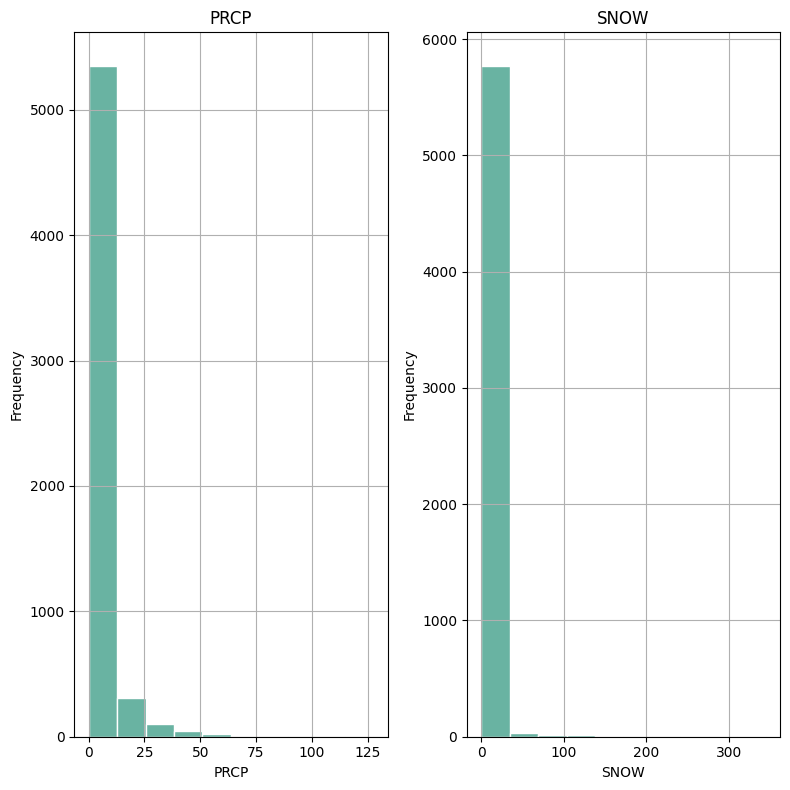

In [50]:
#Convert the downloaded data into a pandas dataframe
s_2=str(data_2.content,'utf-8')
data_s_2 = StringIO(s_2)
climate_2=pd.read_csv(data_s_2)
hist_graph(climate_2, ["PRCP","SNOW"],1,2)

From the above histograms, we see that there are a lot of zeros for these two climate variables in the dataset. Let's convert this data into a matrix and then convert to CSR format.

In [51]:
# Pull only data for CSR conversion
climate_2_df = climate_2[["PRCP","SNOW"]]

# Convert to CSR format
climate_csr = csr_matrix(climate_2_df)

In [52]:
# Show the value array
climate_csr.data

array([  0.8,   5.1,   2. , ...,  20. ,  23.4, 305. ])

In [ ]:
# Sow the column id array
climate_csr.indices

array([0, 0, 0, ..., 1, 0, 1], dtype=int32)

In [53]:
# Show row pointer array
climate_csr.indptr

array([   0,    1,    2, ..., 2113, 2115, 2115], dtype=int32)

##**5. Conclusion**
In this lesson, we first learned why a data matrix needs to be normalized. Then, we introduced 4 methods to normalize a data matrix: standardization, min-max scaling, robust scaling, and time series temporal normalization. We then discussed the challenges and mitigation methods for a sparse data matrix for analysis. Lastly, we talked about how inefficiently a sparse data matrix can be in terms of storage space and computation process. We introduced a method to compress a sparse matrix: compressed sparse row format. CSR reduces the storage requirement of a sparse matrix and makes model calculation with a sparse matrix more efficient.